In [1]:
import cv2

import numpy as np
from robust_line_based_estimator.line_matcher import LineMatcher
from robust_line_based_estimator.visualization import plot_images, plot_lines, plot_color_line_matches
import pygcransac
import pyprogressivex
import seaborn as sns

In [2]:
img0_file = 'img/terrace0.JPG'
img0 = cv2.imread(img0_file, 0)
img1_file = 'img/terrace1.JPG'
img1 = cv2.imread(img1_file, 0)

# LSD+LBD matcher
lsd_lbd_matcher = LineMatcher(line_detector='lsd', line_matcher='lbd')

# SOLD2 matcher
conf = {
    'sold2': {
        'ckpt_path': '../third_party/SOLD2/pretrained_models/sold2_wireframe.tar',
        'device': 'cpu'
    }
}
sold2_matcher = LineMatcher(line_detector='sold2', line_matcher='sold2', conf=conf)

## Line detection and description

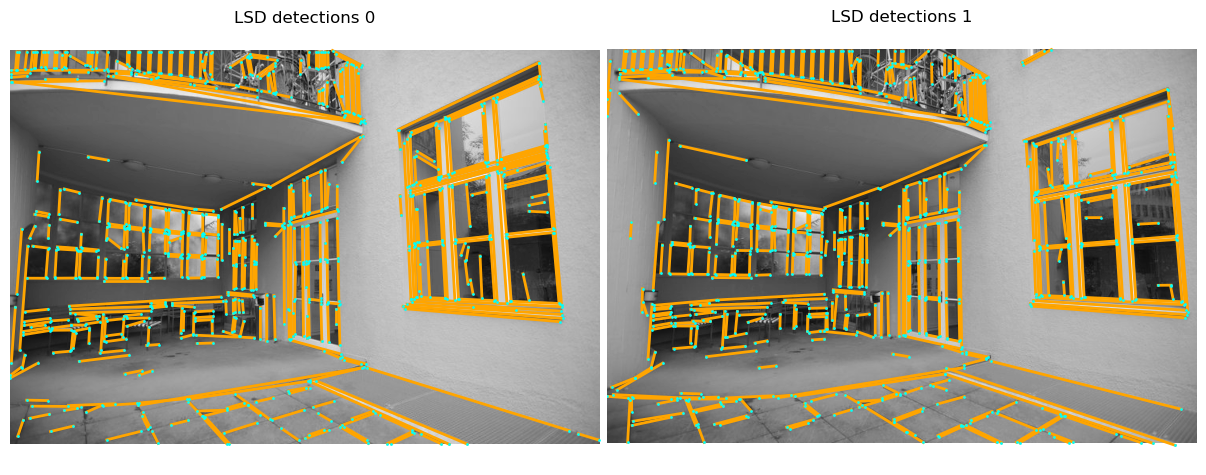

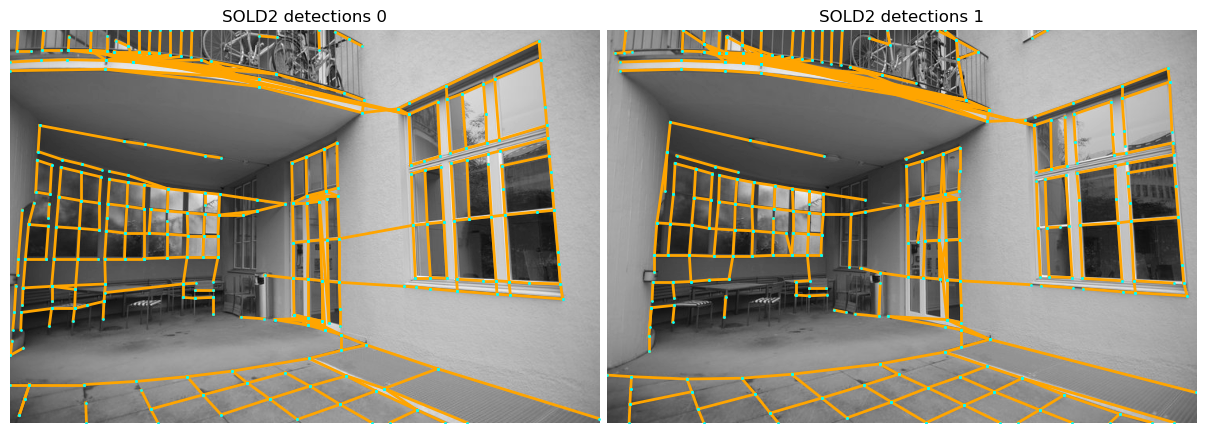

In [3]:
## LSD detections
lsd_lbd_features0 = lsd_lbd_matcher.detect_and_describe_lines(img0)
lsd_lbd_features1 = lsd_lbd_matcher.detect_and_describe_lines(img1)

## SOLD2 detections
sold2_features0 = sold2_matcher.detect_and_describe_lines(img0)
sold2_features1 = sold2_matcher.detect_and_describe_lines(img1)

# Display the detections
plot_images([img0, img1], ['LSD detections 0', 'LSD detections 1'])
plot_lines([lsd_lbd_features0["line_segments"][:, :, [1, 0]], lsd_lbd_features1["line_segments"][:, :, [1, 0]]])
plot_images([img0, img1], ['SOLD2 detections 0', 'SOLD2 detections 1'])
plot_lines([sold2_features0["line_segments"][:, :, [1, 0]], sold2_features1["line_segments"][:, :, [1, 0]]])

## Line matching

Computing LBD matching with ARPACK adjacenceVec size: [2183005 x 1]


/home/danini/anaconda3/envs/homography/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


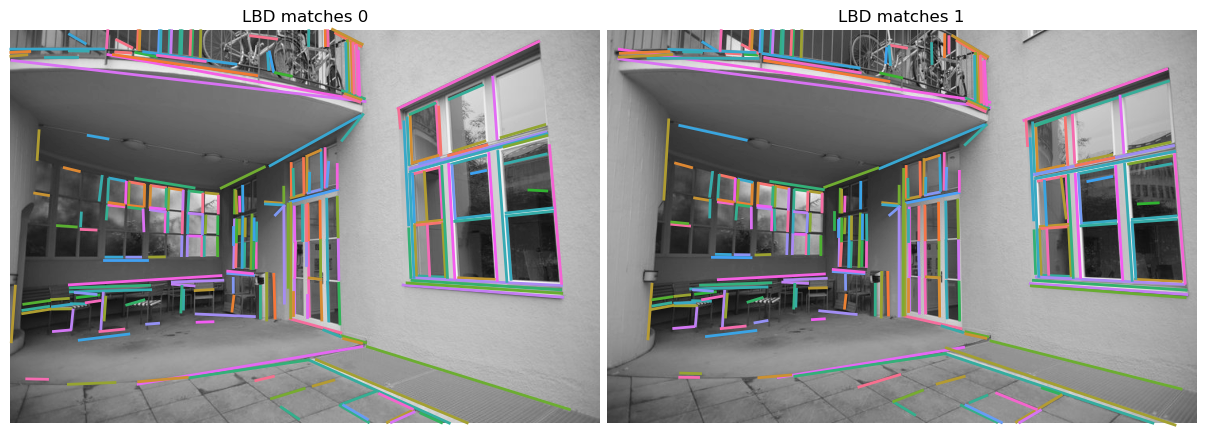

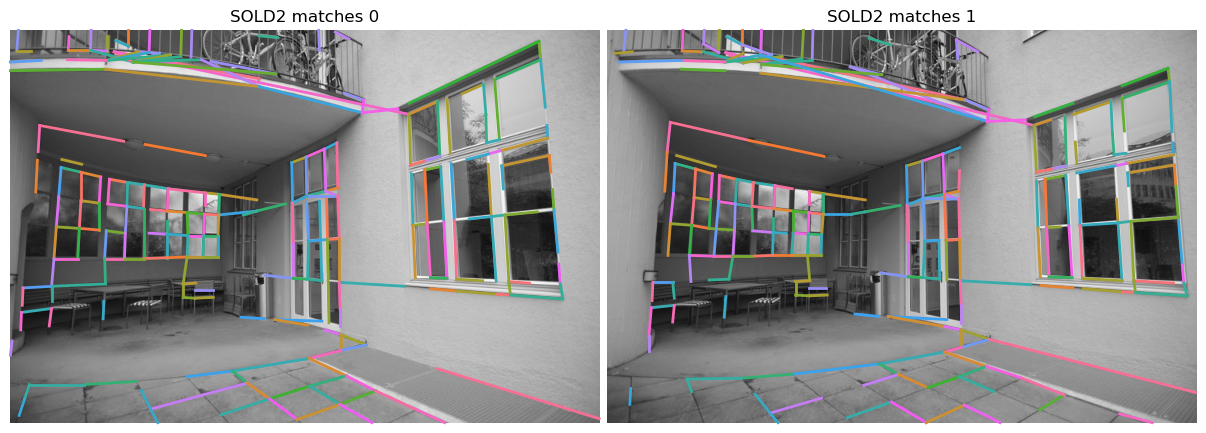

In [4]:
## LBD matching
_, m_lines0_lbd, m_lines1_lbd = lsd_lbd_matcher.match_lines(img0, img1, lsd_lbd_features0, lsd_lbd_features1)

## SOLD2 matching
_, m_lines0_sold2, m_lines1_sold2 = sold2_matcher.match_lines(img0, img1, sold2_features0, sold2_features1)

# Plot the matches
plot_images([img0, img1], ['LBD matches 0', 'LBD matches 1'])
plot_color_line_matches([m_lines0_lbd[:, :, [1, 0]], m_lines1_lbd[:, :, [1, 0]]])
plot_images([img0, img1], ['SOLD2 matches 0', 'SOLD2 matches 1'])
plot_color_line_matches([m_lines0_sold2[:, :, [1, 0]], m_lines1_sold2[:, :, [1, 0]]])

In [89]:
def find_homography_points(lines0, lines1, img1_size, img2_size, threshold = 3.0, confidence = 0.5, minimum_point_number = 10):
    if lines0.shape[0] != lines1.shape[0]:
        print("The number of line segments do not match.")
        return

    line_number = lines0.shape[0]
    correspondences = []

    for i in range(line_number):
        correspondences.append([lines0[i][0][0], lines0[i][0][1], lines1[i][0][0], lines1[i][0][1]])
        correspondences.append([lines0[i][1][0], lines0[i][1][1], lines1[i][1][0], lines1[i][1][1]])
    correspondences = np.array(correspondences).astype(np.float64)
    
    homographies, labeling = pyprogressivex.findHomographies(
        np.ascontiguousarray(correspondences), 
        img1_size[1], img1_size[0], 
        img2_size[1], img2_size[0],
        threshold = threshold,
        conf = confidence,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 200.0,
        maximum_tanimoto_similarity = 0.4,
        max_iters = 1000,
        minimum_point_number = minimum_point_number,
        maximum_model_number = 10,
        sampler_id = 3,
        do_logging = False)   

    model_number = max(labeling)    
    line_labeling = []
    for i in range(line_number):
        idx = 2 * i

        if labeling[idx] == labeling[idx + 1]: 
            line_labeling.append(labeling[idx])
        else:
            line_labeling.append(model_number)

    line_labeling = np.array(line_labeling)
    #for label in range(model_number):
    #    inliers = [index for index, element in enumerate(line_labeling) if element == label]
    #    print(len(inliers))
    #    if len(inliers) < minimum_point_number:
    #        line_labeling[inliers] = model_number

    return homographies, line_labeling


85
49
8
6
4
46
57
7


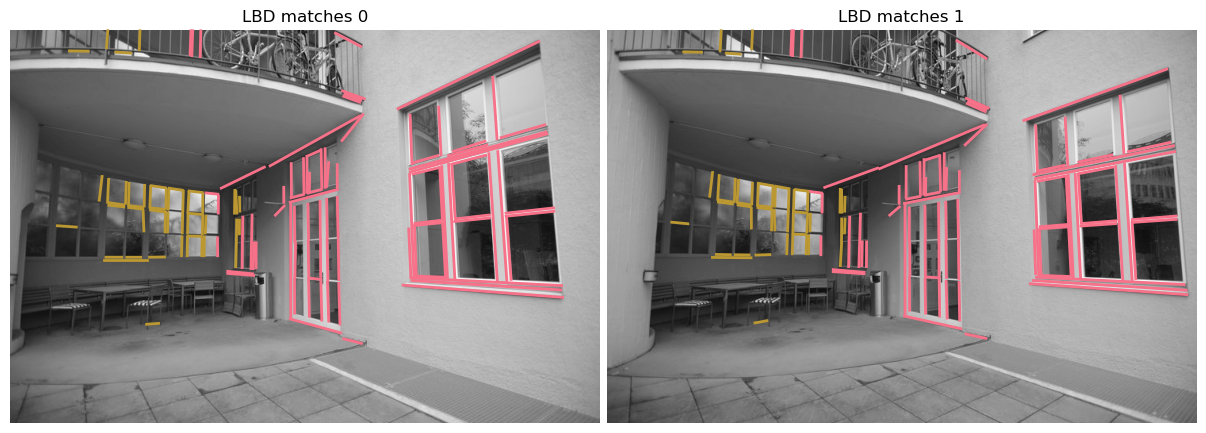

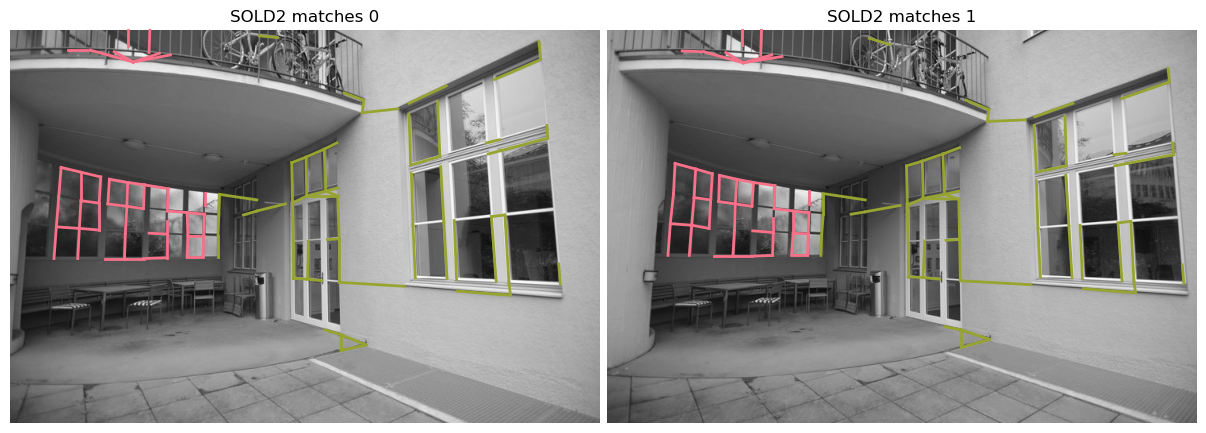

In [90]:
if True:
    m_lines0_lbd_inl = m_lines0_lbd[:, :, [1, 0]]
    m_lines1_lbd_inl = m_lines1_lbd[:, :, [1, 0]]

    homographies, labels = find_homography_points(m_lines0_lbd[:, :, [1, 0]], m_lines1_lbd[:, :, [1, 0]], img0.shape, img1.shape)
    plot_images([img0, img1], ['LBD matches 0', 'LBD matches 1'])
    
    n_homographies = max(labels)
    colors = sns.color_palette('husl', n_colors=n_homographies + 1)

    for label in range(n_homographies):
        inliers = [index for index, element in enumerate(labels) if element == label]
        plot_color_line_matches([m_lines0_lbd_inl[inliers], m_lines1_lbd_inl[inliers]], color = colors[label])

if True:
    m_lines0_sold2_inl = m_lines0_sold2[:, :, [1, 0]]
    m_lines1_sold2_inl = m_lines1_sold2[:, :, [1, 0]]

    homographies, labels = find_homography_points(m_lines0_sold2[:, :, [1, 0]], m_lines1_sold2[:, :, [1, 0]], img0.shape, img1.shape)
    plot_images([img0, img1], ['SOLD2 matches 0', 'SOLD2 matches 1'])
    
    n_homographies = max(labels)
    colors = sns.color_palette('husl', n_colors=n_homographies + 1)

    for label in range(n_homographies):
        inliers = [index for index, element in enumerate(labels) if element == label]
        plot_color_line_matches([m_lines0_sold2_inl[inliers], m_lines1_sold2_inl[inliers]], color = colors[label])